## EmbDI: weights on edges, is it worth the effort? 
In this notebook, I will be looking into the functions that we developed to optimize the EmbDI random walk generation step in the algorithm. In particular, I will focus on how the random walks can be "piloted" to an extent, by assigning weights to the edges in the graph. 

### What is a random walk? 
Quoting the [Wikipedia page](https://en.wikipedia.org/wiki/Random_walk):
> In mathematics, a random walk is a random process that describes a path that consists of a succession of random steps on some mathematical space.

If you take a peek at Wikipedia's page for random walks, you'll find a lot of detail on mathematical models and their application in the real world. 

To try and keep it simple, we will look at the case of random walks on a graph (in this case, EmbDI's graph), and use the following definition for random walk: 

> A random walk on a graph is one of the possible sequences of nodes that can be generated on the graph. These sequences start from a given node, and are generated by iteratively selecting a neighbor of the current node according to certain rules. 

This definition is not particularly rigorous, but it should still be enough to get through this post. I deliberately remained vague when I mentioned "certain rules", because the rules used to select the next step in the random walk are plenty. Indeed, a pretty substantial amount of work during the development of EmbDI was devoted to how the random walks could be selected. 

[Node2Vec](https://dl.acm.org/doi/abs/10.1145/2939672.2939754?casa_token=Q6QjWkY-Z9EAAAAA:ZBrwqhcrl_XJPrltW6Px2RECedM2FpqZAI6uYLFJMfeDvyLrjWw-h55pCKmnCtL2-HEs3wZ_1-IC) is a good example of how to build "intelligent" random walks. 

In [2]:
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib as mpl


In [3]:
plt.style.use('fivethirtyeight')
# Setting the background color to white to avoid issues with dark themes
mpl.rcParams['axes.facecolor']='white'


## A few examples of generic random walks
Let's start this post by plotting a few examples of random walks (not on graphs) to get an idea.  

In [ ]:
x_start, y_start = 0, 0

n_iter = 1000
n_runs = 20

x_coord = np.arange(n_iter)
y_coord = np.zeros(n_iter)

for run in range(n_runs):
    for it in range(1, n_iter):
        # x_coord[it] = x_coord[it - 1] + np.random.randn()
        y_coord[it] = y_coord[it - 1] + np.random.randn()        
    plt.plot(x_coord, y_coord)
plt.show()



In [88]:
# Defining functions

def f_no_smoothing():
    return 1.0

def smooth_exp(x, eps=0.01, target=10, k=0.5):
    t = (eps / (1 - k)) ** (1 / (1 - target))
    y = (1 - k) * t ** (-x + 1) + k
    return y

def inverse_smooth(x, s):
    y = 1 / 2 * (-(1 + s) ** (1 - x) + 2)
    return y

def inverse_freq(freq):
    return 1 / freq

def log_freq(freq, base=10):
    return 1 / (np.log10(freq) + 1)

In [77]:
# Defining x axes
test_frequencies_linear = np.arange(1,10000,1)
test_frequencies_log = np.logspace(0, 4)

In [108]:
def plot_with_params(ax, x, y, x_point=None, y_point=None, title=None, xlim=None, label=None):
    ax.plot(x, y)
    if all([x_point is not None, y_point is not None]):
        ax.plot(x_point, y_point, marker='o')
    ax.set_ylim([0, 1.1])
    if xlim is None:
        ax.set_xlim([0, max(x)])
    else:
        ax.set_xlim(xlim)
    ax.set_title(title)
    if label is not None:
        ax.set_label(label)
    return ax.get_legend_handles_labels

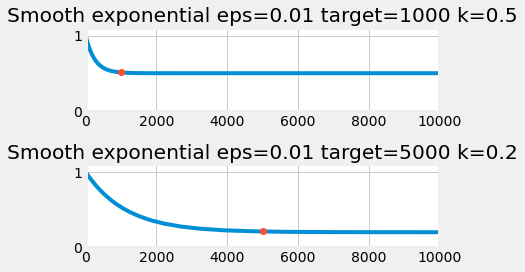

In [119]:
x = test_frequencies_log
fig, axs = plt.subplots(2)
ax1, ax2 = axs


target = 1000
eps = 0.01
k = 0.5
y = smooth_exp(x, target=target, eps=eps, k=k)
y_tgt = smooth_exp(target, target=target, k=k, eps=eps)
title = f'Smooth exponential eps={eps} target={target} k={k}'

plot_with_params(ax1, x, y, target, y_tgt, title)

target = 5000
eps = 0.01
k = 0.2
y = smooth_exp(x, target=target, eps=eps, k=k)
y_tgt = smooth_exp(target, target=target, k=k, eps=eps)
title = f'Smooth exponential eps={eps} target={target} k={k}'

plot_with_params(ax2, x, y, target, y_tgt, title)

plt.tight_layout()


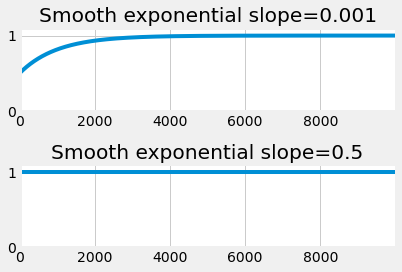

In [122]:
x = test_frequencies_linear
fig, axs = plt.subplots(2)
ax1, ax2 = axs

slope = 0.001
y = inverse_smooth(x, slope)
title = f'Smooth exponential slope={slope}'

plot_with_params(ax1, x, y, title=title)

slope = 0.5
y = inverse_smooth(x, slope)
title = f'Smooth exponential slope={slope}'

plot_with_params(ax2, x, y,  title=title)

plt.tight_layout()


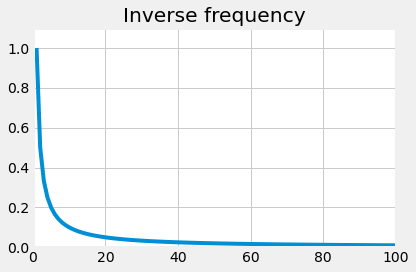

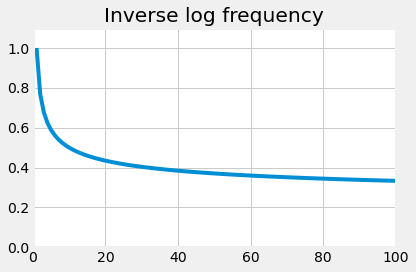

In [123]:
x = test_frequencies_linear
fig1, ax1 = plt.subplots(1)
slope = 0.01
y = inverse_freq(x)
title = f'Inverse frequency'
plot_with_params(ax1, x, y, title, xlim=[0,100], title=title)
plt.tight_layout()
fig1.savefig(f'{title}.pdf')

x = test_frequencies_linear
fig2, ax1 = plt.subplots(1)
slope = 0.01
y = log_freq(x)
title = f'Inverse log frequency'
plot_with_params(ax1, x, y, title, xlim=[0, 100], title=title)
plt.tight_layout()
fig2.savefig(f'{title}.pdf')